In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sentence_transformers import SentenceTransformer

from deepctr.models import DeepFM

import ast
from tqdm import tqdm
tqdm.pandas()


/home/niranjan/miniconda3/envs/deepctr/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Raw Pre-processed data

In [2]:
raw_recipe_df_original = pd.read_csv("preprocessed_data/raw_recipe_preprocessed.csv")
raw_interaction_df_original = pd.read_csv("preprocessed_data/raw_interaction_preprocessed.csv")

In [3]:
raw_recipe_df = raw_recipe_df_original.copy()
raw_interaction_df = raw_interaction_df_original.copy()

In [4]:
raw_recipe_df.info()
raw_recipe_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                231637 non-null  int64 
 1   minutes           231637 non-null  int64 
 2   tags              231528 non-null  object
 3   nutrition         231637 non-null  object
 4   n_steps           231637 non-null  int64 
 5   steps             231636 non-null  object
 6   ingredients       231637 non-null  object
 7   n_ingredients     231637 non-null  int64 
 8   description_soup  231637 non-null  object
 9   year              231637 non-null  int64 
 10  month             231637 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 19.4+ MB


,id,minutes,tags,nutrition,n_steps,steps,ingredients,n_ingredients,description_soup,year,month
0,137739,55,60 minutes less time make course main ingredie...,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,make choice proceed recipe depending size squa...,winter squash mexican seasoning mixed spice ho...,7,arriba baked winter squash mexican style autum...,2005,9
1,31490,30,30 minutes less time make course main ingredie...,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,preheat oven 425 degrees f press dough bottom ...,prepared pizza crust sausage patty eggs milk s...,6,bit different breakfast pizza recipe calls cru...,2002,6
2,112140,130,time make course preparation main dish chili c...,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,brown ground beef large pot add chopped onions...,ground beef yellow onions diced tomatoes tomat...,13,kitchen chili modified version mom chili hit 2...,2005,2
3,59389,45,60 minutes less time make course main ingredie...,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,place potatoes large pot lightly salted water ...,spreadable cheese garlic herbs new potatoes sh...,11,alouette potatoes super easy great tasting mak...,2003,4
4,44061,190,weeknight time make course main ingredient cui...,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,mix ingredients boil 2 1 2 hours thick pour ja...,tomato juice apple cider vinegar sugar salt pe...,8,amish tomato ketchup canning dh amish mother r...,2002,10


In [5]:
raw_interaction_df.info()
raw_interaction_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   rating     1132367 non-null  int64 
 3   review     1132095 non-null  object
 4   year       1132367 non-null  int64 
 5   month      1132367 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 51.8+ MB


,user_id,recipe_id,rating,review,year,month
0,38094,40893,4,great salad cooked top stove 15 minutes added ...,2003,2
1,1293707,40893,5,simple delicious great chilly fall evening dou...,2011,12
2,8937,44394,4,worked well easy used quite whole package 10oz...,2002,12
3,126440,85009,5,made mexican topping took bunko everyone loved,2010,2
4,57222,85009,5,made cheddar bacon topping adding sprinkling b...,2011,10


## Join the two dataset

In [6]:
raw_recipe_df.isnull().any()

id                  False
minutes             False
tags                 True
nutrition           False
n_steps             False
steps                True
ingredients         False
n_ingredients       False
description_soup    False
year                False
month               False
dtype: bool

In [7]:
data = raw_interaction_df.merge(raw_recipe_df, how="left", left_on="recipe_id", right_on="id", suffixes=('_interaction', '_recipe'))
data.head(2)

,user_id,recipe_id,rating,review,year_interaction,month_interaction,id,minutes,tags,nutrition,n_steps,steps,ingredients,n_ingredients,description_soup,year_recipe,month_recipe
0,38094,40893,4,great salad cooked top stove 15 minutes added ...,2003,2,40893,495,weeknight time make course main ingredient pre...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,combine beans onion chilies 1 2 teaspoon cumin...,great northern beans yellow onion diced green ...,9,white bean green chile pepper soup easy soup c...,2002,9
1,1293707,40893,5,simple delicious great chilly fall evening dou...,2011,12,40893,495,weeknight time make course main ingredient pre...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,combine beans onion chilies 1 2 teaspoon cumin...,great northern beans yellow onion diced green ...,9,white bean green chile pepper soup easy soup c...,2002,9


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   user_id            1132367 non-null  int64 
 1   recipe_id          1132367 non-null  int64 
 2   rating             1132367 non-null  int64 
 3   review             1132095 non-null  object
 4   year_interaction   1132367 non-null  int64 
 5   month_interaction  1132367 non-null  int64 
 6   id                 1132367 non-null  int64 
 7   minutes            1132367 non-null  int64 
 8   tags               1131344 non-null  object
 9   nutrition          1132367 non-null  object
 10  n_steps            1132367 non-null  int64 
 11  steps              1132365 non-null  object
 12  ingredients        1132367 non-null  object
 13  n_ingredients      1132367 non-null  int64 
 14  description_soup   1132367 non-null  object
 15  year_recipe        1132367 non-null  int64 
 16  

In [9]:
data.isnull().any()

user_id              False
recipe_id            False
rating               False
review                True
year_interaction     False
month_interaction    False
id                   False
minutes              False
tags                  True
nutrition            False
n_steps              False
steps                 True
ingredients          False
n_ingredients        False
description_soup     False
year_recipe          False
month_recipe         False
dtype: bool

In [10]:
columns_to_fill_empty_string = ["review", "tags", "steps"]
data[columns_to_fill_empty_string] = data[columns_to_fill_empty_string].fillna(' ')

In [11]:
data.isnull().any()

user_id              False
recipe_id            False
rating               False
review               False
year_interaction     False
month_interaction    False
id                   False
minutes              False
tags                 False
nutrition            False
n_steps              False
steps                False
ingredients          False
n_ingredients        False
description_soup     False
year_recipe          False
month_recipe         False
dtype: bool

In [12]:
data.head(2)

,user_id,recipe_id,rating,review,year_interaction,month_interaction,id,minutes,tags,nutrition,n_steps,steps,ingredients,n_ingredients,description_soup,year_recipe,month_recipe
0,38094,40893,4,great salad cooked top stove 15 minutes added ...,2003,2,40893,495,weeknight time make course main ingredient pre...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,combine beans onion chilies 1 2 teaspoon cumin...,great northern beans yellow onion diced green ...,9,white bean green chile pepper soup easy soup c...,2002,9
1,1293707,40893,5,simple delicious great chilly fall evening dou...,2011,12,40893,495,weeknight time make course main ingredient pre...,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,combine beans onion chilies 1 2 teaspoon cumin...,great northern beans yellow onion diced green ...,9,white bean green chile pepper soup easy soup c...,2002,9


In [13]:
text_columns_to_drop = ["review", "tags", "steps", "ingredients", "description_soup"]
soup_column = ["review", "tags", "steps", "ingredients", "description_soup"]

def make_soup(x):
    global soup_column
    result = ""
    for column in soup_column:
        result += x[column] + " "
    return result 

make_soup(data.iloc[0])

'great salad cooked top stove 15 minutes added shake cayenne pinch salt used low fat sour cream thanks weeknight time make course main ingredient preparation occasion soups stews beans vegetables easy crock pot slow cooker dietary equipment combine beans onion chilies 1 2 teaspoon cumin garlic powder broth crock pot cook low 8 hours high 4 hours stir cilantro olive oil remaining 1 2 teaspoon cumin garnish sour cream desired great northern beans yellow onion diced green chilies ground cumin garlic powder fat free chicken broth fresh cilantro leaves extra virgin olive oil sour cream white bean green chile pepper soup easy soup crockpot '

In [14]:
data["soup"] = data.progress_apply(make_soup, axis=1)

  0%|          | 0/1132367 [00:00<?, ?it/s]

100%|██████████| 1132367/1132367 [00:18<00:00, 60492.23it/s]


In [15]:
data = data.drop(text_columns_to_drop, axis=1)

In [16]:
data.head()

,user_id,recipe_id,rating,year_interaction,month_interaction,id,minutes,nutrition,n_steps,n_ingredients,year_recipe,month_recipe,soup
0,38094,40893,4,2003,2,40893,495,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,2002,9,great salad cooked top stove 15 minutes added ...
1,1293707,40893,5,2011,12,40893,495,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,9,2002,9,simple delicious great chilly fall evening dou...
2,8937,44394,4,2002,12,44394,20,"[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,4,2002,10,worked well easy used quite whole package 10oz...
3,126440,85009,5,2010,2,85009,10,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,13,2004,2,made mexican topping took bunko everyone loved...
4,57222,85009,5,2011,10,85009,10,"[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,13,2004,2,made cheddar bacon topping adding sprinkling b...


In [17]:
data["nutrition"] = data["nutrition"].apply(lambda x: ast.literal_eval(x))

In [18]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   user_id            1132367 non-null  int64 
 1   recipe_id          1132367 non-null  int64 
 2   rating             1132367 non-null  int64 
 3   year_interaction   1132367 non-null  int64 
 4   month_interaction  1132367 non-null  int64 
 5   id                 1132367 non-null  int64 
 6   minutes            1132367 non-null  int64 
 7   nutrition          1132367 non-null  object
 8   n_steps            1132367 non-null  int64 
 9   n_ingredients      1132367 non-null  int64 
 10  year_recipe        1132367 non-null  int64 
 11  month_recipe       1132367 non-null  int64 
 12  soup               1132367 non-null  object
dtypes: int64(11), object(2)
memory usage: 1.4 GB


### Text Encoding

In [19]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [20]:
# embeddings = embedding_model.encode(data["soup"])

In [21]:
# embeddings = embeddings.astype(np.float32)
# embeddings.shape, type(embeddings), embeddings.dtype

((1132367, 384), numpy.ndarray, dtype('float32'))

In [33]:
import pickle
filename = 'embeddings.pkl'

# with open(filename, 'wb') as file:
#     pickle.dump(embeddings, file)

# print(f"Embedding saved to {filename}")

In [34]:
with open(filename, 'rb') as file:
    loaded_embedding = pickle.load(file)

In [35]:
loaded_embedding.shape

(1132367, 384)

In [40]:
data["soup_embedding"] = list(loaded_embedding)

### Features

In [41]:
sparse_features = ['user_id', 'recipe_id', 'year_interaction', 'month_interaction', 'minutes', 'n_steps', 'n_ingredients', 'year_recipe', 'month_recipe']
dense_vector = ['soup_embedding']
target = ['rating']
len(sparse_features)

9

In [42]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [43]:
data.head(2)

,user_id,recipe_id,rating,year_interaction,month_interaction,id,minutes,nutrition,n_steps,n_ingredients,year_recipe,month_recipe,soup,soup_embedding
0,3935,22741,4,3,1,40893,353,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,8,3,8,great salad cooked top stove 15 minutes added ...,"[-0.044753153, -0.012271672, 0.038132753, 0.03..."
1,99667,22741,5,11,11,40893,353,"[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,8,3,8,simple delicious great chilly fall evening dou...,"[-0.07353787, -0.03263321, 0.049074758, 0.0873..."


In [44]:
fixlen_feature_columns = [SparseFeat(
    feat,
    vocabulary_size=data[feat].max() + 1, 
    embedding_dim=16
) for feat in sparse_features]

fixlen_feature_columns += [DenseFeat(feat, 384, np.float32) for feat in dense_vector]

In [45]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
len(feature_names), feature_names

(10,
 ['user_id',
  'recipe_id',
  'year_interaction',
  'month_interaction',
  'minutes',
  'n_steps',
  'n_ingredients',
  'year_recipe',
  'month_recipe',
  'soup_embedding'])

In [46]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names if name not in dense_vector}
test_model_input = {name: test[name].values for name in feature_names if name not in dense_vector}

In [48]:
train_model_input["soup_embedding"] = np.array(train["soup_embedding"].tolist())
test_model_input["soup_embedding"] = np.array(test["soup_embedding"].tolist())
train_model_input.keys()

dict_keys(['user_id', 'recipe_id', 'year_interaction', 'month_interaction', 'minutes', 'n_steps', 'n_ingredients', 'year_recipe', 'month_recipe', 'soup_embedding'])

In [49]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )

In [55]:
EPOCHS = 5
BATCH_SIZE = 512

In [56]:
len(train_model_input["recipe_id"]), len(test_model_input["recipe_id"]), type(train_model_input["recipe_id"])

(905893, 226474, numpy.ndarray)

In [57]:
history = model.fit(train_model_input, 
                    train[target].values, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    validation_split=0.2, )

Epoch 1/5
1416/1416 - 48s - loss: 1.3057 - mse: 1.2873 - val_loss: 1.3095 - val_mse: 1.2773
Epoch 2/5
1416/1416 - 48s - loss: 0.8130 - mse: 0.7727 - val_loss: 1.3916 - val_mse: 1.3442
Epoch 3/5
1416/1416 - 48s - loss: 0.6869 - mse: 0.6354 - val_loss: 1.4399 - val_mse: 1.3837
Epoch 4/5
1416/1416 - 48s - loss: 0.5345 - mse: 0.4789 - val_loss: 1.5297 - val_mse: 1.4728
Epoch 5/5
1416/1416 - 48s - loss: 0.4437 - mse: 0.3884 - val_loss: 1.5770 - val_mse: 1.5206


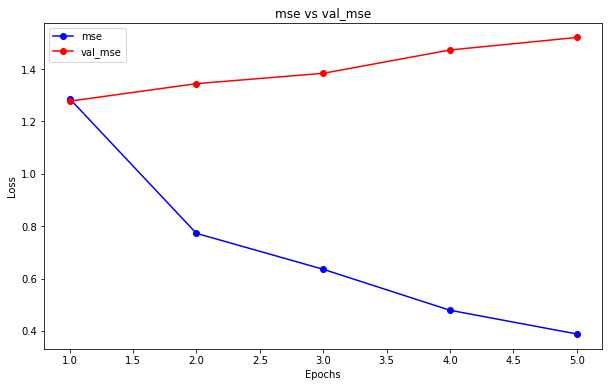

In [58]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "mse", "val_mse")

In [59]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))

test MSE 1.5062
